# 前提条件

| 項目   | 内容                           |
|------|------------------------------|
| 概要   | 顧客満足度アンケートの Data             |
| 対象期間 | 2019年１月 ~ ４月                 |
| 保存方法 | Database                     |
| 目的   | 顧客満足度の向上                     |
| 変数   | アンケートの取得日, Comment, 満足度（５段階） |

In [1]:
import pandas as pd

survey = pd.read_csv('sample_code/chapter_10/survey.csv')
print(len(survey))
survey.head()

86


,datetime,comment,satisfaction
0,2019/3/11,駅前に若者が集まっている(AA駅),1
1,2019/2/25,スポーツできる場所があるのが良い,5
2,2019/2/18,子育て支援が嬉しい,5
3,2019/4/9,保育園に入れる（待機児童なし）,4
4,2019/1/6,駅前商店街が寂しい,2


In [2]:
survey.isna().sum()

datetime        0
comment         2
satisfaction    0
dtype: int64

Comment に２つ欠損値を確認。
欠損値を除去する。

In [3]:
survey = survey.dropna()
survey.isna().sum()

datetime        0
comment         0
satisfaction    0
dtype: int64

不要な文字を除去する。

In [4]:
survey['comment'] = survey['comment'].str.replace('AA', '')
survey['comment'].head()

0     駅前に若者が集まっている(駅)
1    スポーツできる場所があるのが良い
2           子育て支援が嬉しい
3     保育園に入れる（待機児童なし）
4           駅前商店街が寂しい
Name: comment, dtype: object

括弧内が補足的な情報なので除去する。※正規表現を利用

In [5]:
survey['comment'] = survey['comment'].str.replace('\(.+?\)', '', regex=True)
survey.head()

,datetime,comment,satisfaction
0,2019/3/11,駅前に若者が集まっている,1
1,2019/2/25,スポーツできる場所があるのが良い,5
2,2019/2/18,子育て支援が嬉しい,5
3,2019/4/9,保育園に入れる（待機児童なし）,4
4,2019/1/6,駅前商店街が寂しい,2


全角の括弧が残っているの除去する

In [6]:
survey['comment'] = survey['comment'].str.replace('（.+?\）', '', regex=True)
survey.head()

,datetime,comment,satisfaction
0,2019/3/11,駅前に若者が集まっている,1
1,2019/2/25,スポーツできる場所があるのが良い,5
2,2019/2/18,子育て支援が嬉しい,5
3,2019/4/9,保育園に入れる,4
4,2019/1/6,駅前商店街が寂しい,2


In [7]:
survey['length'] = survey['comment'].str.len()
survey.head()

,datetime,comment,satisfaction,length
0,2019/3/11,駅前に若者が集まっている,1,12
1,2019/2/25,スポーツできる場所があるのが良い,5,16
2,2019/2/18,子育て支援が嬉しい,5,9
3,2019/4/9,保育園に入れる,4,7
4,2019/1/6,駅前商店街が寂しい,2,9


(array([11., 24., 21., 10.,  6.,  6.,  5.,  0.,  0.,  1.]),
 array([ 4. ,  8.6, 13.2, 17.8, 22.4, 27. , 31.6, 36.2, 40.8, 45.4, 50. ]),
 <BarContainer object of 10 artists>)

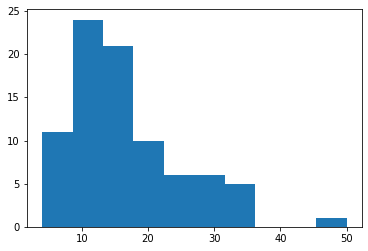

In [8]:
import matplotlib.pyplot as plt

plt.hist(survey['length'])

10 ~ 15文字あたりに Peak が見える。
比較的一言の Comment が多いアンケートの様子。

In [9]:
import MeCab  # Libray の Import

tagger = MeCab.Tagger()  # 初期化
text = 'すもももももももものうち'  # 形態素解析を行なう文章を指定
words = tagger.parse(text)  # 形態素解析を実施
words

'すもも\t名詞,一般,*,*,*,*,すもも,スモモ,スモモ\nも\t助詞,係助詞,*,*,*,*,も,モ,モ\nもも\t名詞,一般,*,*,*,*,もも,モモ,モモ\nも\t助詞,係助詞,*,*,*,*,も,モ,モ\nもも\t名詞,一般,*,*,*,*,もも,モモ,モモ\nの\t助詞,連体化,*,*,*,*,の,ノ,ノ\nうち\t名詞,非自立,副詞可能,*,*,*,うち,ウチ,ウチ\nEOS\n'

In [10]:
words = tagger.parse(text).splitlines()
words_arr = []

for i in words:
    if i == 'EOS': continue
    word_tmp = i.split()[0]
    words_arr.append(word_tmp)

words_arr

['すもも', 'も', 'もも', 'も', 'もも', 'の', 'うち']

In [11]:
text = 'すもももももももものうち'
words = tagger.parse(text).splitlines()
words_arr = []
parts = ['名詞', '動詞']

for i in words:
    if i == 'EOS' or i == '': continue
    word_tmp = i.split()[0]
    part = i.split()[1].split(',')[0]
    if not part in parts: continue
    words_arr.append(word_tmp)

words_arr

['すもも', 'もも', 'もも', 'うち']

どういった Keyword が使われている時に満足度が高いかを見ていく必要がある。
「駅」等の名詞だけでもその文章が何についているか特徴付けることとができると考え、「名詞」のみに絞って分析していく。

In [18]:
all_words = []
parts = ['名詞']

for n in range(len(survey)):
    text = survey['comment'].iloc[n]
    words = tagger.parse(text).splitlines()
    words_arr = []
    for i in words:
        if i == 'EOS' or '': continue
        word_tmp = i.split()[0]
        part = i.split()[1].split(',')[0]
        if not part in parts: continue
        words_arr.append(word_tmp)
    all_words.extend(words_arr)

print(all_words)

['駅前', '若者', 'スポーツ', '場所', 'の', '子育て', '支援', '保育園', '駅前', '商店', '街', '生活', '便利', '場所', '場所', '商業', '施設', '病院', '充実', 'サイクリング', 'コース', '祭り', '小学校', '綺麗', '公園', '近く', '公園', 'スーパー', 'の', '大変', '子育て', 'デートスポット', '商店', '街', '夜道', 'ゴミ', '処理', '楽', '映画', '館', '街路', '樹', '公園', '追加', '観光', 'スポット', '子育て', '道', '綺麗', '都内', 'アクセス', '家賃', 'リーズナブル', 'BBB', '渋滞', '商店', '街', '屋根', '雨', '大変', '商店', '街', 'たくさん', '喫茶店', 'スポーツ', 'ジム', '利用', 'スポーツ', 'ジム', '利用', '料金', 'ママ', '支援', 'バス', '自転車', 'ランニング', '運動', '場所', '有名', '企業', '駅前', '駐車', '場', '変', 'おじさん', '声', '事', '警察', '巡回', '強化', '消防', '団', '活発', '安心', '災害', '時', '避難', '場所', '気', '最近', '川', '氾濫', '被害', '町', 'よう', '氾濫', '防止', '説明', '信号', '交差点', 'ｘｘｘ', '事故', 'そう', '信号', '商店', '街', '活性', '化', '活動', '行政', '後押し', '子ども', '安全', '場所', '駅前', '駐輪場', '不便', '街路', '樹', '落ち葉', '掃除', '大変', '街路', '樹', '災害', '時', '備蓄', '状況', '歩道', '道', '安心', '地域', '自治体', '支援', '自治体', '活動', '頻繁', '安心', '観光', '地', '最近', '県', 'ナンバー', '車', '防犯', 'の', '駐車', '場', '数', '料金', '駅前', '公共', '駐車', '場

単語毎に数え上げるため Dataframe に格納し集計を実施して、頻出単語を５つ表示してみる。

In [19]:
all_words_df = pd.DataFrame({'words': all_words, 'count': len(all_words) * [1]})  # DataFrame に格納、count 列をついでに作成し１を代入。
all_words_df = all_words_df.groupby('words').sum()  # count を単語毎に集計
all_words_df.sort_values('count', ascending=False).head()

,count
words,
駅前,7
場所,6
街,6
の,5
公園,5


「の」が Noise のような単語で発生している。

In [21]:
stop_words = ['の']
all_words = []
parts = ['名詞']

for n in range(len(survey)):
    text = survey['comment'].iloc[n]
    words = tagger.parse(text).splitlines()
    words_arr = []
    for i in words:
        if i == 'EOS' or i == '': continue
        word_tmp = i.split()[0]
        part = i.split()[1].split(',')[0]
        if not part in parts: continue
        if word_tmp in stop_words :continue
        words_arr.append(word_tmp)
    all_words.extend(words_arr)

print(all_words)

['駅前', '若者', 'スポーツ', '場所', '子育て', '支援', '保育園', '駅前', '商店', '街', '生活', '便利', '場所', '場所', '商業', '施設', '病院', '充実', 'サイクリング', 'コース', '祭り', '小学校', '綺麗', '公園', '近く', '公園', 'スーパー', '大変', '子育て', 'デートスポット', '商店', '街', '夜道', 'ゴミ', '処理', '楽', '映画', '館', '街路', '樹', '公園', '追加', '観光', 'スポット', '子育て', '道', '綺麗', '都内', 'アクセス', '家賃', 'リーズナブル', 'BBB', '渋滞', '商店', '街', '屋根', '雨', '大変', '商店', '街', 'たくさん', '喫茶店', 'スポーツ', 'ジム', '利用', 'スポーツ', 'ジム', '利用', '料金', 'ママ', '支援', 'バス', '自転車', 'ランニング', '運動', '場所', '有名', '企業', '駅前', '駐車', '場', '変', 'おじさん', '声', '事', '警察', '巡回', '強化', '消防', '団', '活発', '安心', '災害', '時', '避難', '場所', '気', '最近', '川', '氾濫', '被害', '町', 'よう', '氾濫', '防止', '説明', '信号', '交差点', 'ｘｘｘ', '事故', 'そう', '信号', '商店', '街', '活性', '化', '活動', '行政', '後押し', '子ども', '安全', '場所', '駅前', '駐輪場', '不便', '街路', '樹', '落ち葉', '掃除', '大変', '街路', '樹', '災害', '時', '備蓄', '状況', '歩道', '道', '安心', '地域', '自治体', '支援', '自治体', '活動', '頻繁', '安心', '観光', '地', '最近', '県', 'ナンバー', '車', '防犯', '駐車', '場', '数', '料金', '駅前', '公共', '駐車', '場', '歩行', '者', '

In [25]:
all_words_df = pd.DataFrame({'words': all_words, 'count': len(all_words)*[1]})
all_words_df = all_words_df.groupby('words').sum()
all_words_df.sort_values('count', ascending=False).head()

,count
words,
駅前,7
場所,6
街,6
公園,5
商店,5


In [30]:
stop_words = ['の']
parts = ['名詞']
all_words = []
satisfaction = []
for n in range(len(survey)):
    text = survey['comment'].iloc[n]
    words = tagger.parse(text).splitlines()
    words_arr = []
    for i in words:
        if i == 'EOS' or i == '': continue
        word_tmp = i.split()[0]
        part = i.split()[1].split(',')[0]
        if not part in parts: continue
        if word_tmp in stop_words: continue
        words_arr.append(word_tmp)
        satisfaction.append(survey['satisfaction'].iloc[n])
    all_words.extend(words_arr)

all_words_df = pd.DataFrame({'words': all_words, 'satisfaction': satisfaction, 'count': len(all_words) *[1]})
all_words_df.head()

,words,satisfaction,count
0,駅前,1,1
1,若者,1,1
2,スポーツ,5,1
3,場所,5,1
4,子育て,5,1


In [31]:
words_satisfaction = all_words_df.groupby('words').mean()['satisfaction']
words_count = all_words_df.groupby('words').sum()['count']
words_df = pd.concat([words_satisfaction, words_count], axis=1)
words_df.head()

,satisfaction,count
words,,
BBB,2.0,1
^^,5.0,1
おじさん,1.0,1
ごみ,2.0,1
そう,1.0,1


In [32]:
words_df = words_df.loc[words_df['count'] >= 3]
words_df.sort_values('satisfaction', ascending=False).head()

,satisfaction,count
words,,
子育て,4.333333,3
綺麗,4.333333,3
安心,4.333333,3
スポーツ,3.666667,3
道,3.000000,3


In [33]:
words_df.sort_values('satisfaction').head()

,satisfaction,count
words,,
駐車,1.000000,4
場,1.000000,4
信号,1.333333,3
大変,1.333333,3
駅前,1.428571,7


満足度の高い Keyword: 子育てなど
満足度の低い Keyword: 駐車など